<a href="https://colab.research.google.com/github/BabarMuaz/skinDiseaseDetection/blob/main/autoKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy data to colab dir
!cp -rf /content/drive/MyDrive/superCleanedSKinDataset /content

# to remove this folder
#%rm -rf Splitted_SuperCleanedDataset_70_20_10 

In [ ]:
# imporitng required libraries

#general
import itertools
import numpy as np # it is confusion matrix and classification function dependency 
import matplotlib.pyplot as plt #  it is training plots func dependency

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # to save model and early stopping
from tensorflow.keras.metrics import categorical_crossentropy # loss function
from tensorflow.keras import layers # used when model is build Sequentially
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data processing function
from tensorflow.keras.optimizers import Adam # optimizer
# sklearn
from sklearn.metrics import classification_report,confusion_matrix # to generate confusion matrix and classification summary




#import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense , MaxPool2D   
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
import os.path
import glob
import shutil
import random as rn
from sklearn.metrics import classification_report,confusion_matrix
import cv2

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

In [ ]:
classes = ["melanoma", "nevus"]
val_ratio = 0.10
test_ratio = 0.05

for cls in classes:
  if not os.path.exists("skin_disease/train/"+ cls):
    os.makedirs('skin_disease/train/' + cls)
  if not os.path.exists("skin_disease/val/"+ cls):
    os.makedirs('skin_disease/val/' + cls)
  if not os.path.exists("skin_disease/test/"+ cls):
    os.makedirs('skin_disease/test/' + cls)


  # Creating partitions of the data after shuffeling
  src = '/content/superCleanedSKinDataset/' + cls # Folder to copy images from

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))
  print('Testing: ', len(test_FileNames))

  # Copy-pasting images
  for name in train_FileNames:
    shutil.copy(name, 'skin_disease/train/' + cls)

  for name in val_FileNames:
    shutil.copy(name, 'skin_disease/val/' + cls)

  for name in test_FileNames:
    shutil.copy(name,'skin_disease/test/' + cls)

Total images:  2813
Training:  2391
Validation:  281
Testing:  141
Total images:  2911
Training:  2474
Validation:  291
Testing:  146


In [ ]:
train_data_dir = "/content/skin_disease/train"
test_data_dir = "/content/skin_disease/test"
val_data_dir = "/content/skin_disease/val"

In [ ]:
print('Total melanoma images in Training Data:', len(os.listdir(train_data_dir+"/melanoma")))
print('Total nevus images in Training Data:', len(os.listdir(train_data_dir+"/nevus")))
print('Total melanoma images in Validation Data:', len(os.listdir(val_data_dir+"/melanoma")))
print('Total nevus images in Validation Data:', len(os.listdir(val_data_dir+"/nevus")))
print('Total melanoma images in Test Data:', len(os.listdir(test_data_dir+"/melanoma")))
print('Total nevus images in Test Data:', len(os.listdir(test_data_dir+"/nevus")))

Total melanoma images in Training Data: 2391
Total nevus images in Training Data: 2474
Total melanoma images in Validation Data: 281
Total nevus images in Validation Data: 291
Total melanoma images in Test Data: 141
Total nevus images in Test Data: 146


In [ ]:
# get paths to fetch data
# train_path = "/content/Splitted_SuperCleanedDataset_70_20_10/train"
# valid_path = "/content/Splitted_SuperCleanedDataset_70_20_10/val"
# test_path = "/content/Splitted_SuperCleanedDataset_70_20_10/test"

train_path = train_data_dir
valid_path = val_data_dir
test_path = test_data_dir

In [ ]:
# Create Data Batches for training
size = 224

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
                                         directory=train_path, 
                                         target_size=(size,size),  
                                         batch_size=3904,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
                                         directory=valid_path, target_size=(size,size),
                                         batch_size=1088,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
                                         directory=test_path, 
                                         target_size=(size,size), 
                                         batch_size=564,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

Found 4865 images belonging to 2 classes.
Found 572 images belonging to 2 classes.
Found 287 images belonging to 2 classes.


In [ ]:
# checking how classes are labelled, somestimes depending on the server folders are stored alphabatelly or not
print("training data labelled as = ",train_batches.class_indices)
print("validation data labelled as = ",valid_batches.class_indices)
print("testing data labelled as = ",test_batches.class_indices)

training data labelled as =  {'melanoma': 0, 'nevus': 1}
validation data labelled as =  {'melanoma': 0, 'nevus': 1}
testing data labelled as =  {'melanoma': 0, 'nevus': 1}


In [ ]:
(x_train, y_train) = next(train_batches)  # creating one batch for training images, purpose is to put data on ram faster execution

In [ ]:
(x_test, y_test) = next(valid_batches)  # creating one batch for validation images, purpose is to put data on ram faster execution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

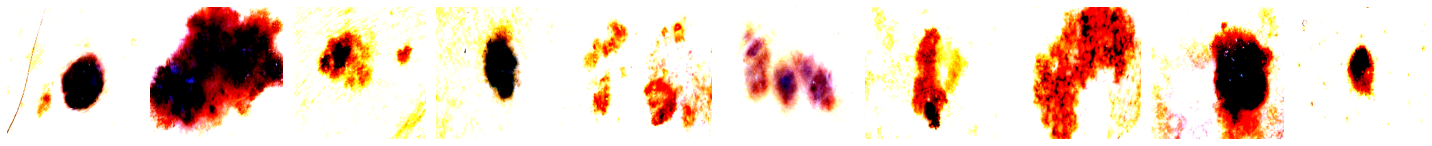

[0. 0. 0. ... 1. 1. 1.]


In [ ]:
# function to see images in Datagen, this is used to see images after preprocessing step
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(x_train)
print(y_train)

In [ ]:
# above ImageDataGenerator function along with next is used to put data on ram
# when data is on ram training is very quick, CAUTION: only do this if your dataset can fit on ram
# if dataaugmentation, than apply here
# datagen = ImageDataGenerator(		
#     horizontal_flip=True,
# 		vertical_flip=True,
# 		zoom_range=[0.65,0.85],
# 		rotation_range=270)  # data in batches is fed to model using this 

datagen = ImageDataGenerator()      

In [ ]:
pip install autokeras

     |████████████████████████████████| 160 kB 3.9 MB/s 
     |████████████████████████████████| 98 kB 9.3 MB/s 
     |████████████████████████████████| 462 kB 46.3 MB/s 


In [ ]:
import autokeras as ak

In [ ]:
clf = ak.ImageClassifier()

INFO:tensorflow:Reloading Oracle from existing project ./image_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


In [ ]:
clf.fit(x_train, y_train)

Trial 24 Complete [00h 05m 45s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 03h 50m 33s
INFO:tensorflow:Oracle triggered exit
122/122 [==============================] - 28s 182ms/step - loss: 0.4638 - accuracy: 0.9524
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


In [ ]:
model=clf.export_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 224, 224, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                             

In [ ]:
model.save('autoKeras_bestModel.hdf5')

In [ ]:
!cp /content/autoKeras_bestModel.hdf5 /content/drive/MyDrive/Upwork/DiseaseClass

In [ ]:
loaded_model = load_model("/content/drive/MyDrive/Upwork/DiseaseClass/autoKeras_bestModel.hdf5", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 224, 224, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                             